In [1]:
import numpy as np
from scipy import special, optimize
from math import factorial as fact
import matplotlib.pyplot as plt
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from mpl_toolkits.axes_grid1 import make_axes_locatable


plt.rcParams['font.size'] = 15
plt.rcParams["axes.labelsize"] = 15
pd.options.display.float_format = "{:.4f}".format

# image

In [2]:
def para(a,b,theta):
    alpha = np.sqrt(a**2*np.cos(theta)**2 + b**2*np.sin(theta)**2)
    beta  = np.sqrt(b**2*np.cos(theta)**2 + a**2*np.sin(theta)**2)
    gamma = np.sin(2*theta)*(a**2-b**2)/(2*alpha*beta)
    return alpha,beta,gamma


def k(alpha, beta, gamma):
    """normalizing constant for PSF"""
    K = beta*alpha*np.sqrt(1 - gamma*gamma) / (2*np.pi)
    return K


def integrate_lim(x,y,thetaX,thetaY,alpha,beta,a):
    """integration limits for mu_prime"""
    u1 = alpha * (x-thetaX-a/2)
    u2 = alpha * (x-thetaX+a/2)
    v1 = beta  * (y-thetaY-a/2)
    v2 = beta  * (y-thetaY+a/2)
    return u1,u2,v1,v2
   
    
def numIntegrand_muP(x,y1,y2,gamma):
    """integrand of mu_prime, integrate over x, constants y1 & y2"""
    deltaErf = special.erf((y2+x*gamma)/np.sqrt(2))-special.erf((y1+x*gamma)/np.sqrt(2)) 
    integrand = np.sqrt(np.pi/2) * np.exp(x*x*(gamma*gamma-1)/2)*deltaErf
    return integrand


def numIntegrate(x1,x2,y1,y2,gamma,numSteps,integrand):
    """numerical integration of mu_prime, integration over x"""
    x = np.linspace(x1,x2,numSteps)
    h = (x2-x1)/(numSteps-1)
    trapzSum = 0
    for i in range(len(x)):
        trapzSum += integrand(x[i],y1,y2,gamma) * h
    trapzSum = trapzSum - h/2 * (integrand(x[0],y1,y2,gamma)+integrand(x[-1],y1,y2,gamma))
    return trapzSum


def mu_prime(x,y,thetaX,thetaY,alpha, beta, gamma,a,numSteps):
    """integrate analytically and numerically"""
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha,beta,a)
    mu_p = np.zeros(x.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            maxVal = max([abs(val) for val in [u1[i,j],u2[i,j],v1[i,j],v2[i,j]]])
            if maxVal == abs(u1[i,j]) or maxVal == abs(u2[i,j]):
                #integrate numerically over u
                mu_p[i,j] = numIntegrate(u1[i,j],u2[i,j],v1[i,j],v2[i,j],gamma,numSteps,numIntegrand_muP)
            elif maxVal == abs(v1[i,j]) or maxVal == abs(v2[i,j]):
                mu_p[i,j] = numIntegrate(v1[i,j],v2[i,j],u1[i,j],u2[i,j],gamma,numSteps,numIntegrand_muP)
    return mu_p



def mu(x,y,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg):
    """image model for gaussian psf"""
    K1 = k(alpha1, beta1, gamma1)
    K2 = k(alpha2, beta2, gamma2)
    mu_p1 = mu_prime(x,y,X1,Y1,alpha1,beta1,gamma1,a,numSteps)
    mu_p2 = mu_prime(x,y,X2,Y2,alpha2,beta2,gamma2,a,numSteps)
    mu = I1*K1*mu_p1/alpha1/beta1 + I2*K2*mu_p2/alpha2/beta2 + thetabg*a**2
    return mu


# test image

photon count sim: 19.9990
photon count true: 20.0002
alpha1=0.42, beta1=0.42, gamma1=-0.38, theta1=0.25Pi
alpha2=0.85, beta2=0.85, gamma2=0.38, theta2=0.75Pi
X1=9.50, Y1=9.50, X2=14.50, Y2=14.50
xmax=24, a=0.2, bg=1e-05,


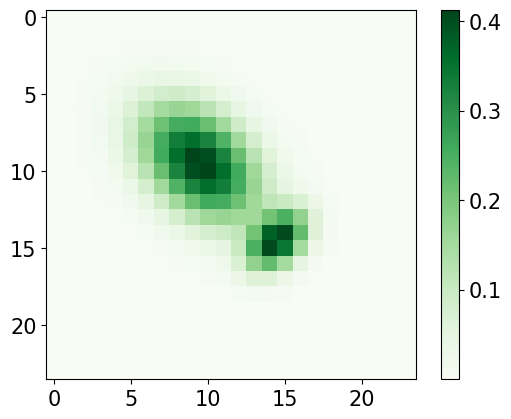

In [3]:
theta1, theta2 = np.pi/4, np.pi/4*3
width1 = 3
height1 = 2
width2 = 1.5
height2 = 1
alpha1,beta1,gamma1 = para(1/width1,1/height1,theta1)
alpha2,beta2,gamma2 = para(1/width2,1/height2,theta2)

xmax = 3*8
ymax = xmax
X = (xmax-1)/2
Y = X
X1 = X-2
Y1 = Y-2
X2 = X+3
Y2 = Y+3
a = 0.2
thetabg = 1e-5
numSteps = 30
I1 = 400
I2 = 100

x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)
m = mu(xs, ys,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
plt.imshow(m,cmap="Greens")
plt.colorbar();

print(f'photon count sim: {np.sum(m):.4f}')
print(f'photon count true: {a**2*thetabg*xmax**2+I1*a**2+I2*a**2:.4f}')
print(f"alpha1={alpha1:.2f}, beta1={beta1:.2f}, gamma1={gamma1:.2f}, theta1={theta1/np.pi}Pi")
print(f"alpha2={alpha2:.2f}, beta2={beta2:.2f}, gamma2={gamma2:.2f}, theta2={theta2/np.pi}Pi")
print(f"X1={X1:.2f}, Y1={Y1:.2f}, X2={X2:.2f}, Y2={Y2:.2f}")
print(f"xmax={xmax}, a={a}, bg={thetabg},")

# retrieve rotated for same image para

two overlapping ellipses with N=250
photon count code: 43.0399
photon count true: 43.0400
alpha1=0.42, beta1=0.42, gamma1=-0.38, xmax=24, a=0.2, bg=1, rotation1=0.25Pi


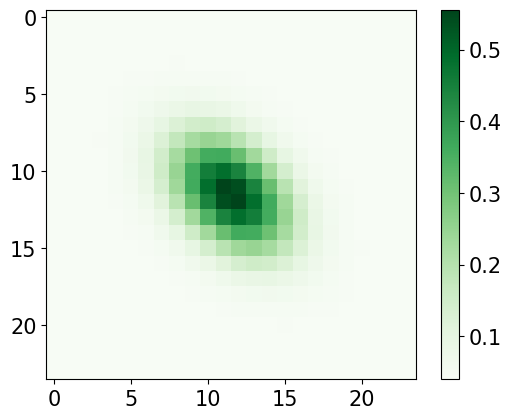

In [4]:
theta1, theta2 = np.pi/4, np.pi/4
width1 = 3
height1 = 2
width2 = 3
height2 = 2
alpha1,beta1,gamma1 = para(1/width1,1/height1,theta1)
alpha2,beta2,gamma2 = para(1/width2,1/height2,theta2)

xmax = 3*8
ymax = xmax
X = (xmax-1)/2
Y = X
X1 = X
Y1 = Y
X2 = X
Y2 = Y
a = 0.2
thetabg = 1
numSteps = 30
I1 = 250
I2 = 250

x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)
m = mu(xs, ys,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
plt.imshow(m,cmap="Greens")
plt.colorbar();

print("two overlapping ellipses with N=250")
print(f'photon count code: {np.sum(m):.4f}')
print(f'photon count true: {a**2*thetabg*xmax**2+(I1+I2)*a**2:.4f}')
print(f"alpha1={alpha1:.2f}, beta1={beta1:.2f}, gamma1={gamma1:.2f}, xmax={xmax}, a={a}, bg={thetabg}, rotation1={theta1/np.pi}Pi")

# test counts

In [5]:
theta1, theta2 = np.pi/4, np.pi/4*3
width1 = 3
height1 = 2
width2 = 1.5
height2 = 1
alpha1,beta1,gamma1 = para(1/width1,1/height1,theta1)
alpha2,beta2,gamma2 = para(1/width2,1/height2,theta2)

xmax = 3*8
ymax = xmax
X = (xmax-1)/2
Y = X
X1 = X-2
Y1 = Y-2
X2 = X+3
Y2 = Y+3
a = np.arange(0.2,1,0.05)
thetabg = 1e-5
numSteps = 30
I1 = 400
I2 = 100

x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)
m = [np.sum(mu(xs, ys,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a[i],numSteps,thetabg)) for i in range(len(a))]
mT = a**2*thetabg*xmax**2 + (I1+I2)*a**2


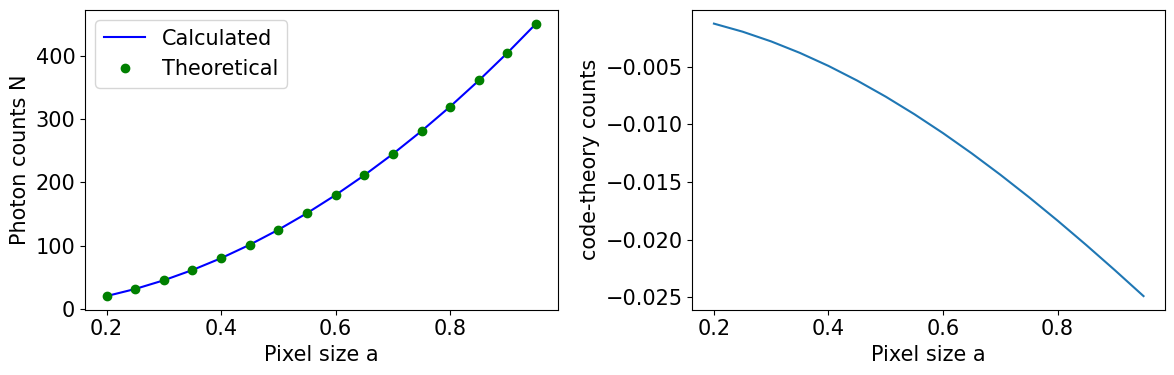

In [6]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(a,m,"b", label="Calculated")
ax[0].plot(a,mT,"go", label="Theoretical")
ax[0].set_xlabel("Pixel size a")
ax[0].set_ylabel("Photon counts N")
ax[0].legend()

ax[1].plot(a, m-mT)
ax[1].set_xlabel("Pixel size a")
ax[1].set_ylabel("code-theory counts")
fig.tight_layout()

# bounds

In [3]:
def dmu_dthetaI0(x,y,thetaX,thetaY,a,numSteps,alpha, beta, gamma):
    """derivative of mu wrt thetaI0"""
    K = k(alpha, beta, gamma)
    mu_p = mu_prime(x,y,thetaX,thetaY,alpha, beta, gamma,a,numSteps)
    dmu_dthetaI0 = K/alpha/beta * mu_p
    return dmu_dthetaI0


def dmu_dthetabg(a):
    """derivative of mu wrt thetabg"""
    d = a**2
    return d


def dErf(x,y1,y2,gamma):
    """delta error functions for thetaX, thetaY derivatives"""
    deltaErf = special.erf((y1+x*gamma)/np.sqrt(2))-special.erf((y2+x*gamma)/np.sqrt(2)) 
    return deltaErf


def dmu_dthetaX(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0):
    """derivative of mu wrt thetaX"""
    K = k(alpha, beta, gamma)/alpha/beta
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha,beta,a)
    derf_u1 = dErf(u1,v2,v1,gamma)
    derf_u2 = dErf(u2,v2,v1,gamma)
    bracket = np.exp(u2*u2*(gamma*gamma-1)/2)*derf_u2 - np.exp(u1*u1*(gamma*gamma-1)/2)*derf_u1
    dmu_dthetaX = thetaI0*K*(-alpha)*np.sqrt(np.pi/2)*bracket
    return dmu_dthetaX


def dmu_dthetaY(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0):
    """derivative of mu wrt thetaY"""
    K = k(alpha, beta, gamma)/alpha/beta
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha,beta,a)
    derf_v1 = dErf(v1,u2,u1,gamma)
    derf_v2 = dErf(v2,u2,u1,gamma)
    bracket = np.exp(v2*v2*(gamma*gamma-1)/2)*derf_v2 - np.exp(v1*v1*(gamma*gamma-1)/2)*derf_v1
    dmu_dthetaY = thetaI0*K*(-beta)*np.sqrt(np.pi/2)*bracket
    return dmu_dthetaY


def dK(alpha, beta, gamma, dAlpha=False, dBeta=False, dGamma=False):
    """derivatives of K wrt alpha, beta, gamma"""
    if dAlpha:
        dK = beta*np.sqrt(1-gamma*gamma)/(2*np.pi)
    elif dBeta: 
        dK = alpha*np.sqrt(1-gamma*gamma)/(2*np.pi)
    elif dGamma:
        dK = -alpha*beta*gamma/(2*np.pi*np.sqrt(1-gamma*gamma))
    return dK


def dmu_dalpha(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0, numSteps):
    """derivative of image model wrt alpha"""
    K = k(alpha, beta, gamma)
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha,beta,a)
    derf_u1 = dErf(u1,v2,v1,gamma)
    derf_u2 = dErf(u2,v2,v1,gamma)
    mu_p = mu_prime(x,y,thetaX,thetaY,alpha, beta, gamma,a,numSteps)
    bracket = np.exp(u2*u2*(gamma*gamma-1)/2)*derf_u2*(x-thetaX+a/2)- np.exp(u1*u1*(gamma*gamma-1)/2)*derf_u1*(x-thetaX-a/2) 
    dK_dalpha = dK(alpha, beta, gamma, dAlpha=True)
    dmuP_dalpha = np.sqrt(np.pi/2)*bracket
    dmu_dalpha = -thetaI0/beta * (dK_dalpha*mu_p/alpha - K*mu_p/alpha**2 + K/alpha*dmuP_dalpha)
    return dmu_dalpha


def dmu_dbeta(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps):
    """derivative of image model wrt beta"""
    K = k(alpha, beta, gamma)
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha,beta,a)
    derf_v1 = dErf(v1,u2,u1,gamma)
    derf_v2 = dErf(v2,u2,u1,gamma)
    mu_p = mu_prime(x,y,thetaX,thetaY,alpha, beta, gamma,a,numSteps)
    bracket = np.exp(v2*v2*(gamma*gamma-1)/2)*derf_v2*(y-thetaY+a/2) - np.exp(v1*v1*(gamma*gamma-1)/2)*derf_v1*(y-thetaY-a/2)
    dK_dbeta = dK(alpha, beta, gamma, dBeta=True)
    dmuP_dbeta = np.sqrt(np.pi/2)*bracket
    dmu_dbeta = -thetaI0/alpha * (dK_dbeta*mu_p/beta - K*mu_p/beta**2 + K/beta*dmuP_dbeta)
    return dmu_dbeta


def dmuPrime_dGamma_integrand(x,y1,y2,gamma):
    """derivative of mu_prime wrt gamma integrand"""
    #integrate over x
    brac1 = 2+np.exp((y1+x*gamma)**2/2)*np.sqrt(2*np.pi)*x*gamma*special.erf((y1+x*gamma)/np.sqrt(2))
    brac2 = 2+np.exp((y2+x*gamma)**2/2)*np.sqrt(2*np.pi)*x*gamma*special.erf((y2+x*gamma)/np.sqrt(2))
    p1 = np.exp(-y1**2/2-0.5*x*(x+2*y1*gamma))*brac1
    p2 = np.exp(-y2**2/2-0.5*x*(x+2*y2*gamma))*brac2
    integrand = 0.5*x*(p2-p1)
    return integrand


def dmuPrime_dGamma(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps):
    """derivative of mu_prime wrt gamma"""
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha,beta,a)
    dmuPrime_dGamma = np.zeros(x.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            maxVal = max([abs(i) for i in [u1[i,j],u2[i,j],v1[i,j],v2[i,j]]])
            if maxVal == abs(u1[i,j]) or maxVal == abs(u2[i,j]):
                #integrate numerically over u
                dmuPrime_dGamma[i,j] = numIntegrate(u1[i,j],u2[i,j],v1[i,j],v2[i,j],gamma,numSteps,dmuPrime_dGamma_integrand)
            elif maxVal == abs(v1[i,j]) or maxVal == abs(v2[i,j]):
                dmuPrime_dGamma[i,j] =  numIntegrate(v1[i,j],v2[i,j],u1[i,j],u2[i,j],gamma,numSteps,dmuPrime_dGamma_integrand)
    return dmuPrime_dGamma


def dmu_dgamma(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps):
    """derivative of image model wrt gamma"""
    K = k(alpha, beta, gamma)
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha,beta,a)
    dK_dgamma = dK(alpha, beta, gamma, dGamma=True)
    mu_p = mu_prime(x,y,thetaX,thetaY,alpha, beta, gamma,a,numSteps)
    dmuP_dgamma = dmuPrime_dGamma(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps)
    dmu_dgamma = thetaI0/alpha/beta * (K*dmuP_dgamma + dK_dgamma*mu_p)
    return dmu_dgamma

In [4]:
def takeDer(para,x,y,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps):
    """take derivatives options"""
    if para == "X1":
        der = dmu_dthetaX(x,y,X1,Y1,a,alpha1,beta1,gamma1,I1)
    elif para == "Y1":
        der = dmu_dthetaY(x,y,X1,Y1,a,alpha1,beta1,gamma1,I1)
    elif para == "I1":
        der = dmu_dthetaI0(x,y,X1,Y1,a,numSteps,alpha1, beta1, gamma1)
    elif para == "alpha1":
        der = dmu_dalpha(x,y,X1,Y1,a,alpha1,beta1,gamma1,I1, numSteps)
    elif para == "beta1":
        der = dmu_dbeta(x,y,X1,Y1,a,alpha1,beta1,gamma1,I1,numSteps)
    elif para == "gamma1":
        der = dmu_dgamma(x,y,X1,Y1,a,alpha1,beta1,gamma1,I1,numSteps)
        
    elif para == "X2":
        der = dmu_dthetaX(x,y,X2,Y2,a,alpha2,beta2,gamma2,I2)
    elif para == "Y2":
        der = dmu_dthetaY(x,y,X2,Y2,a,alpha2,beta2,gamma2,I2)
    elif para == "I2":
        der = dmu_dthetaI0(x,y,X2,Y2,a,numSteps,alpha2, beta2, gamma2)
    elif para == "alpha2":
        der = dmu_dalpha(x,y,X2,Y2,a,alpha2,beta2,gamma2,I2, numSteps)
    elif para == "beta2":
        der = dmu_dbeta(x,y,X2,Y2,a,alpha2,beta2,gamma2,I2,numSteps)
    elif para == "gamma2":
        der = dmu_dgamma(x,y,X2,Y2,a,alpha2,beta2,gamma2,I2,numSteps)
        
    elif para == "thetabg":
        der = dmu_dthetabg(a)
    return der


def fisher(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg):
    """calculate fisher matrix"""
    paras = ["X1", "Y1", "I1", "alpha1", "beta1","gamma1",
            "X2", "Y2", "I2", "alpha2", "beta2","gamma2","thetabg"]
    n = len(paras)
    fisher = np.zeros((n,n))
    
    x, y = np.arange(xmax), np.arange(ymax)
    xs, ys = np.meshgrid(x,y)
    ys = np.flipud(ys)
    mus= mu(xs,ys,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg)

    for i in range(n):
        for j in range(n):
            fisher[i,j] = np.sum(1/mus * takeDer(paras[i],xs,ys,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps) * \
                                 takeDer(paras[j],xs,ys,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps))
    return fisher


def crlb(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg):
    """inverse fisher, retrieve CRLBs"""
    fisherM = fisher(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
    fisherInv = np.linalg.inv(fisherM)
    crlbs = [fisherInv[i,i] for i in range(len(fisherM))]
    print("#",end="")
    return crlbs


# no correction, separation test

In [29]:
theta1, theta2 = 0,0
width1 = 2
height1 = 2
width2 = 2
height2 = 2
alpha1,beta1,gamma1 = para(1/width1,1/height1,theta1)
alpha2,beta2,gamma2 = para(1/width2,1/height2,theta2)

xmax = 3*8
ymax = xmax
X = (xmax-1)/2
Y = X
X1 = X
Y1 = Y
X2 = X
Y2 = Y
a = 0.2
thetabg = 1e-5
numSteps = 30
I1 = 500
I2 = 500
sep = np.arange(0.5,8.5,0.5)


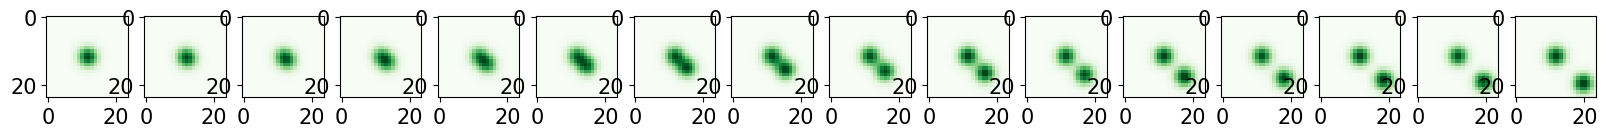

In [30]:
x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)
fig, ax = plt.subplots(1,len(sep),figsize=(20,4))
for i in range(len(sep)):
    m = mu(xs, ys,X1,Y1,alpha1,beta1,gamma1,I1,X2+sep[i],Y2+sep[i],alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
    ax[i].imshow(m,cmap="Greens")

In [31]:
crlbs45 = [crlb(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2+sep[i],Y2+sep[i],alpha2,beta2,gamma2,I2,a,numSteps,thetabg) for i in range(len(sep))]

################

In [33]:
center_bound45 = [crlbs45[i][6]+crlbs45[i][7] for i in range(len(crlbs45))]
offCenter_bound45 = [crlbs45[i][0]+crlbs45[i][1] for i in range(len(crlbs45))]

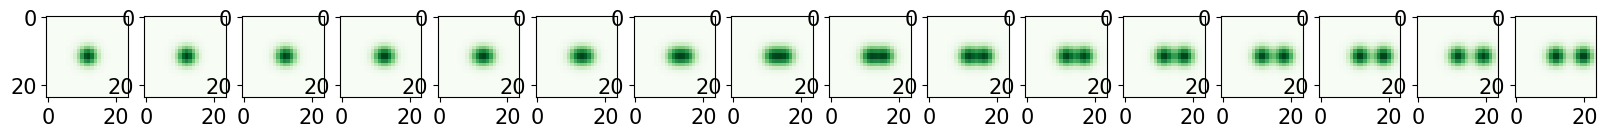

In [34]:
fig, ax = plt.subplots(1,len(sep),figsize=(20,4))
for i in range(len(sep)):
    m = mu(xs, ys,X1,Y1,alpha1,beta1,gamma1,I1,X2+sep[i],Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
    ax[i].imshow(m,cmap="Greens")

In [35]:
crlbs0 = [crlb(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2+sep[i],Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg) for i in range(len(sep))]


################

NameError: name 'crlbs' is not defined

In [36]:
center_bound0 = [crlbs0[i][6]+crlbs0[i][7] for i in range(len(crlbs0))]
offCenter_bound0 = [crlbs0[i][0]+crlbs0[i][1] for i in range(len(crlbs0))]

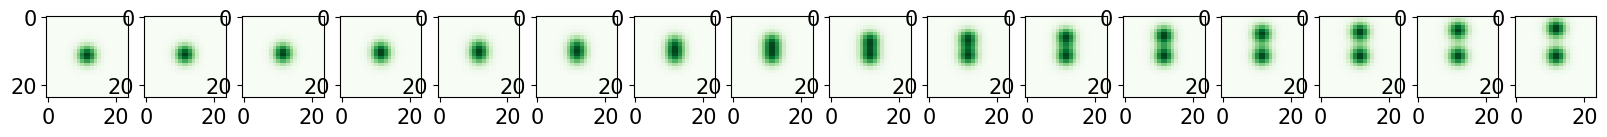

In [37]:
fig, ax = plt.subplots(1,len(sep),figsize=(20,4))
for i in range(len(sep)):
    m = mu(xs, ys,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2-sep[i],alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
    ax[i].imshow(m,cmap="Greens")

In [38]:
crlbs90 = [crlb(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2-sep[i],alpha2,beta2,gamma2,I2,a,numSteps,thetabg) for i in range(len(sep))]
center_bound90 = [crlbs90[i][6]+crlbs90[i][7] for i in range(len(crlbs90))]
offCenter_bound90 = [crlbs90[i][0]+crlbs90[i][1] for i in range(len(crlbs90))]

################

''

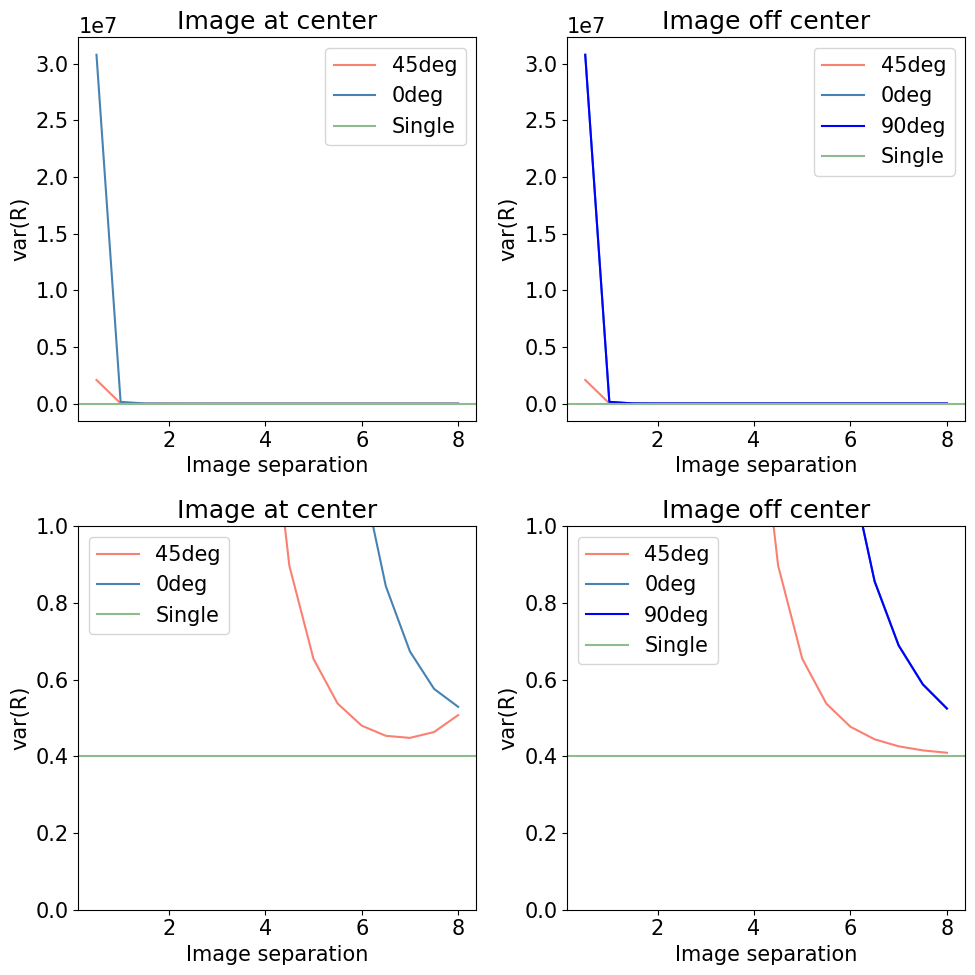

In [61]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
for j in range(2):
    ax[j,0].plot(sep,center_bound45, label="45deg",c="salmon") 
    ax[j,0].plot(sep,center_bound0, label="0deg", c="steelblue")
    #ax[0].plot(sep,center_bound90, label="90deg", c="blue")
    [ax[j,0].set_title("Image at center") for i in range(2)]

    ax[j,1].plot(sep,offCenter_bound45, label="45deg", c="salmon")
    ax[j,1].plot(sep,offCenter_bound0, label="0deg",c="steelblue")
    ax[j,1].plot(sep,offCenter_bound90, label="90deg", c="blue")
    [ax[j,1].set_title("Image off center") for i in range(2)]

    [ax[j,i].axhline(y = 0.40034, label = "Single",c="darkseagreen") for i in range(2)]
    [ax[j,i].set_xlabel("Image separation") for i in range(2)]
    [ax[j,i].set_ylabel("var(R)") for i in range(2)]
    [ax[j,i].legend() for i in range(2)]

[ax[1,i].set_ylim((0,1)) for i in range(2)]
fig.tight_layout()
;

In [47]:
center_bound0

[30773272.48812045,
 146173.81436635612,
 7260.054992852395,
 939.6581855653432,
 203.37810381322316,
 60.53493708136463,
 22.413162374024086,
 9.767601345291887,
 4.857359969356699,
 2.7088078608018473,
 1.67565495375182,
 1.1392873416078242,
 0.8433327202685426,
 0.6731774584575281,
 0.5757230740769471,
 0.5288003103818234]

In [50]:
center_bound90

[30773292.088526603,
 146173.814620429,
 7260.054993061831,
 939.6581855658507,
 203.37810381324203,
 60.53493708135847,
 22.413162374024935,
 9.767601345292137,
 4.857359969356754,
 2.7088078608018407,
 1.6756549537518193,
 1.1392873416078235,
 0.8433327202685432,
 0.6731774584575282,
 0.5757230740769471,
 0.5288003103818235]

In [51]:
center_bound45

[2082139.1475107663,
 11137.906603423708,
 623.7737322385567,
 88.92377265482489,
 20.89298210139181,
 6.774991565051415,
 2.8089132766104346,
 1.4417848304320353,
 0.896264748840219,
 0.6538084611682841,
 0.5374865350835689,
 0.47975845929326477,
 0.45326829818829656,
 0.44791429189329507,
 0.46318392273414655,
 0.5073333109741229]

# test correction

In [5]:
parasL = ["X1", "Y1", "I1", "alpha1", "beta1","gamma1",
            "X2", "Y2", "I2", "alpha2", "beta2","gamma2","thetabg"]

def correct(fisherM):
    F = np.zeros(fisherM.shape)
    fisherInv = np.linalg.inv(fisherM)
    paras = [X1,Y1,I1,alpha1,beta1,gamma1,X2,Y2,I2,alpha2,beta2,gamma2,thetabg]
    
    for i in range(len(fisherM)):
        for j in range(len(fisherM)):
            if i in [0,1,6,7] and j in [0,1,6,7]:
                A = (paras[i] - paras[j])**2/(np.sqrt(fisherInv[i,i])*np.sqrt(fisherInv[j,j]))
                if (i%2 == 0 and j%2 == 0 and i!=j) or (i%2 != 0 and j%2 != 0 and i!=1 and j!=1 and i!=j):
                    F[i,j] = A/(A+1)*fisherM[i,j]
                else:
                    F[i,j] = fisherM[i,j]
    Finv = np.linalg.inv(F)
    return Finv

def correct(fisherM):
    F = fisherM
    fisherInv = np.linalg.inv(fisherM)
    paras = [X1,Y1,I1,alpha1,beta1,gamma1,X2,Y2,I2,alpha2,beta2,gamma2,thetabg]
    
    ind = [[6,0], [0,6],[1,7],[7,1]]
    
    Finv = np.linalg.inv(F)
    return Finv

def noCorrect(fisherM):
    fisherInv = np.linalg.inv(fisherM)
    return fisherInv

def getElements(Finv, fisherInv):
    bc = [Finv[i][i] for i in range(len(parasL))]
    bnc = [fisherInv[i][i] for i in range(len(parasL))]
    p = pd.DataFrame([parasL,bc,bnc],index=["para","Corrected","Not Corrected"]).T
    return p
    


def crlb_Cor(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg):
    """inverse fisher, retrieve CRLBs"""
    fisherM = fisher(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
    fisherInv = correct(fisherM)
    crlbs = [fisherInv[i,i] for i in range(len(fisherM))]
    print("#",end="")
    return crlbs

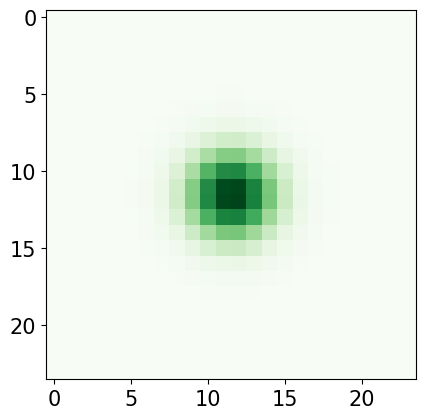

In [22]:
theta1, theta2 = 0,0
width1 = 2
height1 = 2
width2 = 2
height2 = 2
alpha1,beta1,gamma1 = para(1/width1,1/height1,theta1)
alpha2,beta2,gamma2 = para(1/width2,1/height2,theta2)

xmax = 3*8
ymax = xmax
X = (xmax-1)/2
Y = X
X1 = X
Y1 = Y
X2 = X+0.1
Y2 = Y+0.1
a = 0.2
thetabg = 1e-5
numSteps = 30
I1 = 500
I2 = 500

x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)
m = mu(xs, ys,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
plt.imshow(m,cmap="Greens")

fisherM = fisher(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg)

In [12]:
crlb(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg)

#

[71781232443.26537,
 71781136979.05075,
 7.161809415464707e+18,
 311814.0515525523,
 311812.81133751303,
 5003587.129934033,
 71552276230.00331,
 71552371540.80367,
 7.161809322078641e+18,
 308844.7608679481,
 308845.995046739,
 4956058.113228292,
 1.2926920953649733e-06]

In [23]:
F = fisherM.copy()
fisherInv = np.linalg.inv(fisherM)
A60 = 0.1**2/(np.sqrt(fisherInv[6,6])*np.sqrt(fisherInv[0,0]))
F[6,0] = A60/(A60+1)*fisherM[6,0]
F[0,6] = A60/(A60+1)*fisherM[0,6]

A17 = 0.1**2/(np.sqrt(fisherInv[1,1])*np.sqrt(fisherInv[7,7]))
F[1,7] = A17/(A17+1)*fisherM[1,7]
F[7,1] = A17/(A17+1)*fisherM[7,1]

fI = np.linalg.inv(F)
pd.DataFrame(fI)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.2002,-0.2002,-1003.3658,0.0010,-0.0002,-0.0017,-0.2012,-0.2002,1003.3658,0.0015,0.0002,-0.0033,-0.0000
1,-0.2002,0.2002,-1003.3658,-0.0002,0.0010,-0.0017,-0.2002,-0.2012,1003.3658,0.0002,0.0015,-0.0033,-0.0000
2,-1003.3658,-1003.3658,-5016832.2115,-0.7295,-0.7295,4.1946,-1003.3658,-1003.3658,5029332.3150,0.7300,0.7300,-4.1946,-0.0003
3,0.0010,-0.0002,-0.7295,1.4697,0.2093,1.6718,-0.0015,-0.0002,0.7300,-1.4634,-0.2093,-1.6719,-0.0000
4,-0.0002,0.0010,-0.7295,0.2093,1.4697,1.6718,-0.0002,-0.0015,0.7300,-0.2093,-1.4634,-1.6719,-0.0000
5,-0.0017,-0.0017,4.1946,1.6718,1.6718,13.4250,0.0033,0.0033,-4.1945,-1.6719,-1.6719,-13.3747,-0.0000
6,-0.2012,-0.2002,-1003.3658,-0.0015,-0.0002,0.0033,0.2002,-0.2002,1003.3658,-0.0010,0.0002,0.0017,0.0000
7,-0.2002,-0.2012,-1003.3658,-0.0002,-0.0015,0.0033,-0.2002,0.2002,1003.3658,0.0002,-0.0010,0.0017,0.0000
8,1003.3658,1003.3658,5029332.3150,0.7300,0.7300,-4.1945,1003.3658,1003.3658,-5016832.1499,-0.7295,-0.7295,4.1946,-0.0002
9,0.0015,0.0002,0.7300,-1.4634,-0.2093,-1.6719,-0.0010,0.0002,-0.7295,1.4697,0.2093,1.6718,-0.0000


In [29]:
F[0,6]

3.476668337911197e-13

In [30]:
fisherM[0,6]

2.4916121780491656

In [33]:
pd.DataFrame(fisherM)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2.5010,-0.0000,-0.0002,-0.4980,0.0004,0.1244,2.4916,-0.0031,0.0002,-0.4982,0.0003,0.1245,-0.6372
1,-0.0000,2.5010,-0.0002,0.0004,-0.4980,0.1244,-0.0031,2.4916,0.0002,0.0003,-0.4982,0.1245,-0.6372
2,-0.0002,-0.0002,0.0000,-0.0000,-0.0000,0.0000,-0.0002,-0.0002,0.0000,-0.0000,-0.0000,-0.0000,0.0153
3,-0.4980,0.0004,-0.0000,79.9495,-0.0039,0.0001,0.4982,-0.0003,-0.0000,79.5521,-0.0037,0.0497,102.2259
4,0.0004,-0.4980,-0.0000,-0.0039,79.9495,0.0001,-0.0003,0.4982,-0.0000,-0.0037,79.5521,0.0497,102.2259
5,0.1244,0.1244,0.0000,0.0001,0.0001,9.9942,-0.1245,-0.1245,-0.0000,0.0497,0.0497,9.9445,0.0318
6,2.4916,-0.0031,-0.0002,0.4982,-0.0003,-0.1245,2.5010,-0.0000,0.0002,0.4980,-0.0004,-0.1244,0.6337
7,-0.0031,2.4916,-0.0002,-0.0003,0.4982,-0.1245,-0.0000,2.5010,0.0002,-0.0004,0.4980,-0.1244,0.6337
8,0.0002,0.0002,0.0000,-0.0000,-0.0000,-0.0000,0.0002,0.0002,0.0000,-0.0000,-0.0000,0.0000,0.0153
9,-0.4982,0.0003,-0.0000,79.5521,-0.0037,0.0497,0.4980,-0.0004,-0.0000,79.9495,-0.0039,0.0001,102.2146


In [34]:
pd.DataFrame(np.linalg.inv(fisherM))

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,71781232443.2654,71703557230.2999,716753579053748.8750,149404640.5110,148919170.1432,-598978283.7460,71569572785.9036,71647247998.6692,-716753574380623.1250,-148081844.2618,-148567314.6018,595637761.3224,-1.0391
1,71703619594.6089,71781136979.0508,716753413688959.8750,148919628.9667,149404112.8851,-598978145.6034,71647152561.3816,71569635177.1399,-716753409015835.3750,-148566787.1649,-148082303.2328,595637623.8509,-1.0391
2,716753977859394.5000,716753189349704.8750,7161809415464707072.0000,1489822365102.5049,1489817436811.1118,-5982567615548.9600,715608798701432.0000,715609587211123.2500,-7161809368771660800.0000,-1482665767243.7202,-1482670695327.4138,5954048663040.6338,-8860.6039
3,149404473.9763,148919332.8036,1489819872141.6504,311814.0516,308780.6571,-1246028.8209,148559686.3136,149044827.4863,-1489819862427.8757,-306534.2790,-309565.1589,1237056.5503,-0.0028
4,148919393.3957,149404206.5092,1489818838608.6274,308781.4673,311812.8113,-1246027.9575,149044560.1876,148559747.0739,-1489818828894.8611,-309563.9197,-306535.0902,1237055.6911,-0.0028
5,-598978398.7081,-598977740.0259,-5982565435518.5215,-1246030.4499,-1246026.3330,5003587.1299,-597535434.7473,-597536093.4295,5982565396511.6064,1237012.5607,1237016.6774,-4967605.3098,0.0112
6,71569652547.0826,71647170057.8117,715609197507078.5000,148560018.3713,149044503.0804,-597535985.7157,71552276230.0033,71474758719.0739,-715609192841591.3750,-148451494.1561,-147967009.4335,595172714.0802,-0.7330
7,71647265395.5391,71569590309.2609,715609362871868.2500,149045029.9158,148559560.3384,-597536123.8584,71474696454.3249,71552371540.8037,-715609358206380.0000,-147966551.2531,-148452020.8025,595172851.5518,-0.7330
8,-716753973186266.7500,-716753184676582.1250,-7161809368771663872.0000,-1489822355388.7180,-1489817427097.3569,5982567576542.0459,-715608794035947.6250,-715609582545633.7500,7161809322078641152.0000,1482665757577.7004,1482670685661.3621,-5954048624224.0859,8860.6034
9,-148082176.2354,-148566990.1324,-1482668259363.1443,-306535.3135,-309564.1480,1237015.0938,-148451660.6067,-147966846.7098,1482668249697.1086,308844.7609,305813.4119,-1234150.6559,0.0009
